In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import yaml

In [2]:
# import sys
# from pathlib import Path

# # Add project root to sys.path
# project_root = Path(__file__).resolve().parent.parent
# sys.path.append(str(project_root))

from src.config import DATA_INTERIM
from src.config import DATA_PROCESSED

In [4]:
import os
print(os.getcwd())

c:\Users\DELL\Documents\PRAXIS\Projects\onlinefraud_Bank_project


In [5]:
from pathlib import Path
import os, yaml, pandas as pd

try:
    # If running as a script
    PROJECT_ROOT = Path(__file__).resolve().parent
except NameError:
    # If running in Jupyter
    PROJECT_ROOT = Path(os.getcwd())

config_path = PROJECT_ROOT / "config.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

def load_raw_data():
    """Loads the raw dataset from the data/raw directory."""
    raw_path = PROJECT_ROOT / config["data"]["raw"]

    if not raw_path.exists():
        raise FileNotFoundError(f"Dataset not found at {raw_path}")
    
    df = pd.read_csv(raw_path)
    return df


In [6]:
if __name__ == "__main__":
    df = load_raw_data()
    print(f"Dataset shape: {df.shape}")

Dataset shape: (6362620, 11)


In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Class imbalance

In [29]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

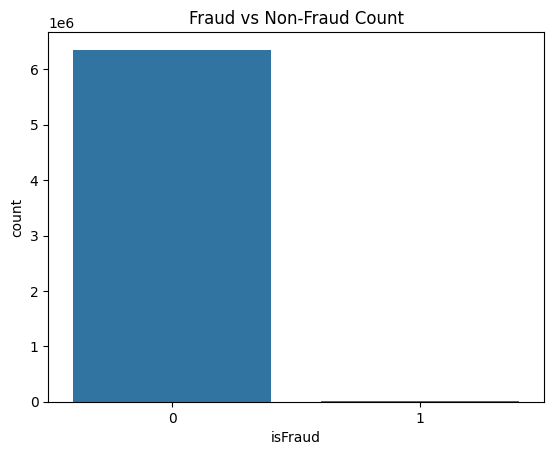

Fraudulent transactions: 0.1291%


In [10]:
sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Non-Fraud Count")
plt.show()

fraud_ratio = df["isFraud"].mean() * 100
print(f"Fraudulent transactions: {fraud_ratio:.4f}%")


### Transaction type distribution

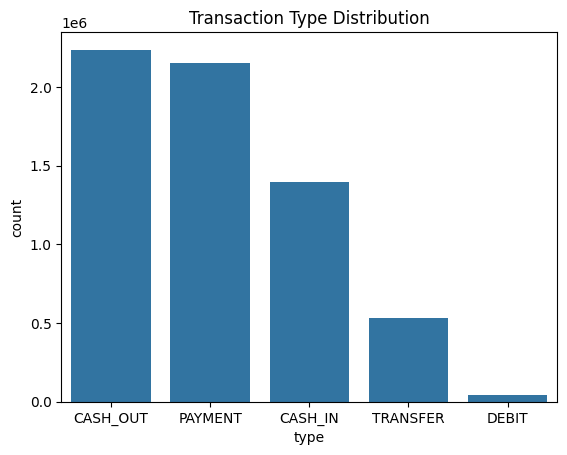

In [11]:
sns.countplot(x="type", data=df, order=df['type'].value_counts().index)
plt.title("Transaction Type Distribution")
plt.show()


### Fraud Rate by Transaction Type

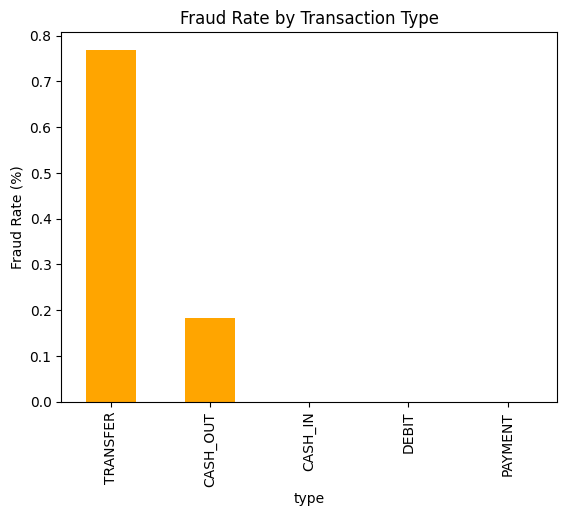

In [12]:
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False) * 100
fraud_by_type.plot(kind='bar', color='orange')
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Transaction Type")
plt.show()

In [13]:
bankDf = df.copy()

In [14]:
bankDf['balance_diff_orig'] = bankDf['oldbalanceOrg'] - bankDf['newbalanceOrig']
bankDf['balance_diff_dest'] = bankDf['newbalanceDest'] - bankDf['oldbalanceDest']
bankDf['flag_dest_new_account'] = (bankDf['oldbalanceDest'] == 0).astype(int)
bankDf['transaction_hour'] = bankDf['step'] % 24
bankDf['is_high_amount'] = (bankDf['amount'] > bankDf['amount'].quantile(0.95)).astype(int)

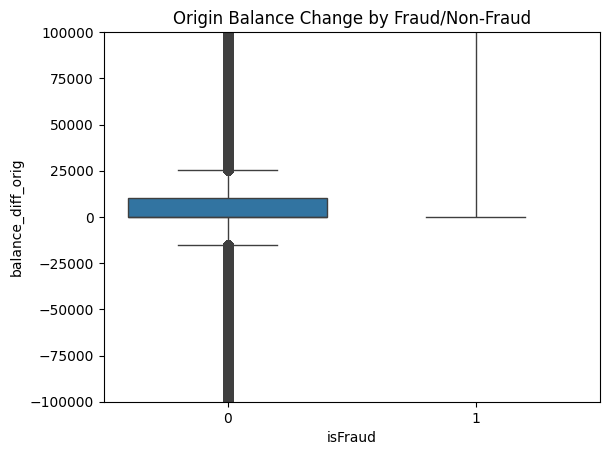

In [15]:
sns.boxplot(x="isFraud", y="balance_diff_orig", data=bankDf)
plt.title("Origin Balance Change by Fraud/Non-Fraud")
plt.ylim(-1e5, 1e5)
plt.show()

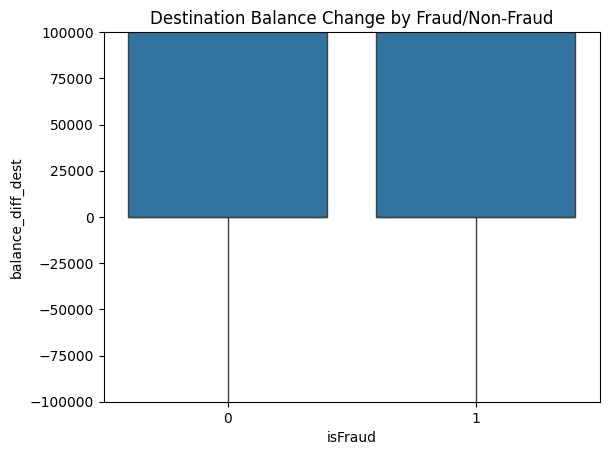

In [16]:
sns.boxplot(x="isFraud", y="balance_diff_dest", data=bankDf)
plt.title("Destination Balance Change by Fraud/Non-Fraud")
plt.ylim(-1e5, 1e5)
plt.show()


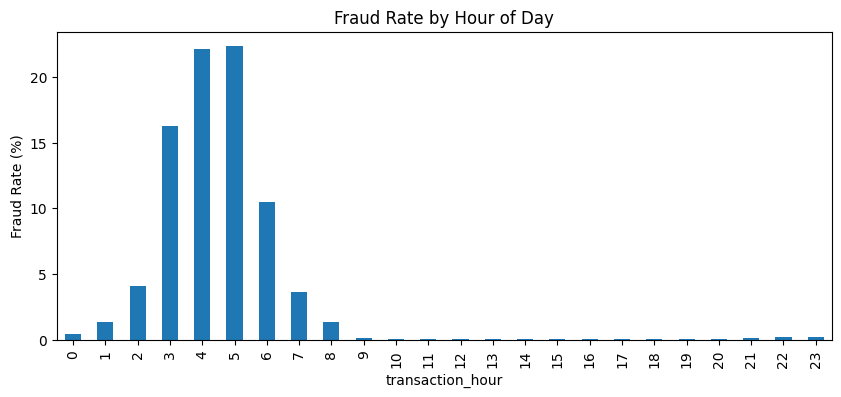

In [16]:
fraud_by_hour = bankDf.groupby("transaction_hour")["isFraud"].mean() * 100
fraud_by_hour.plot(kind="bar", figsize=(10,4))
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Hour of Day")
plt.show()


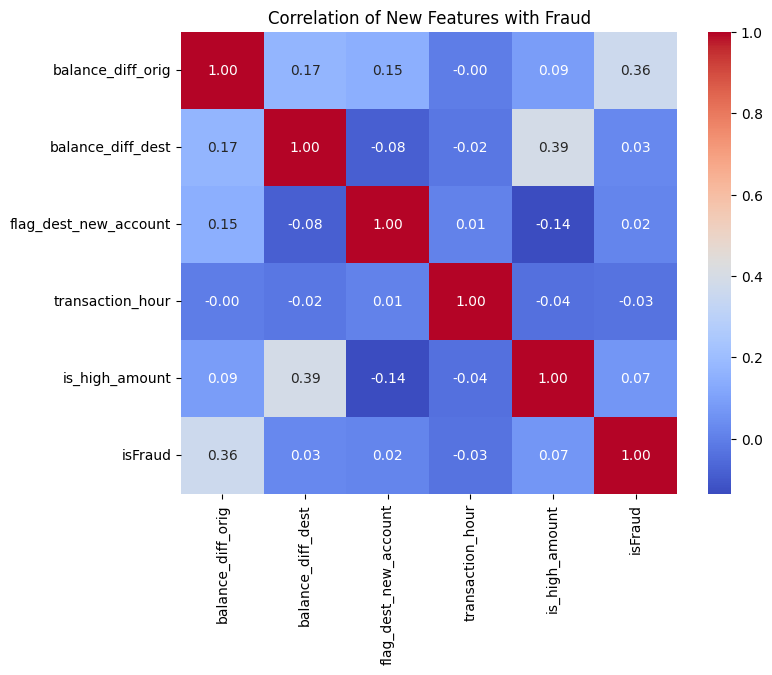

In [18]:
plt.figure(figsize=(8,6))
corr = bankDf[["balance_diff_orig", "balance_diff_dest", "flag_dest_new_account",
               "transaction_hour", "is_high_amount", "isFraud"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of New Features with Fraud")
plt.show()

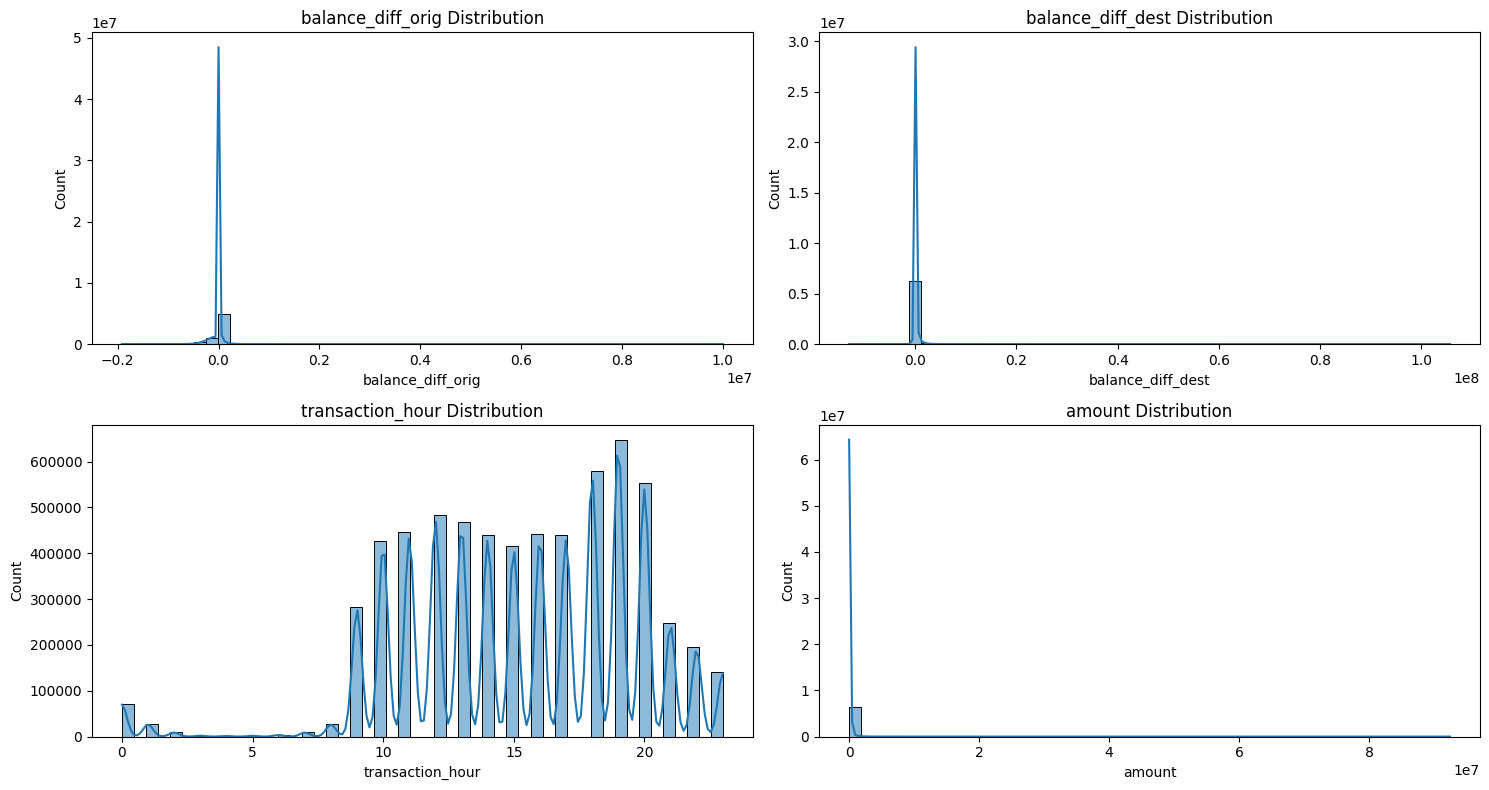

In [19]:
num_features = ['balance_diff_orig', 'balance_diff_dest', 'transaction_hour', 'amount']
plt.figure(figsize=(15,8))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(bankDf[col], kde=True, bins=50)
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

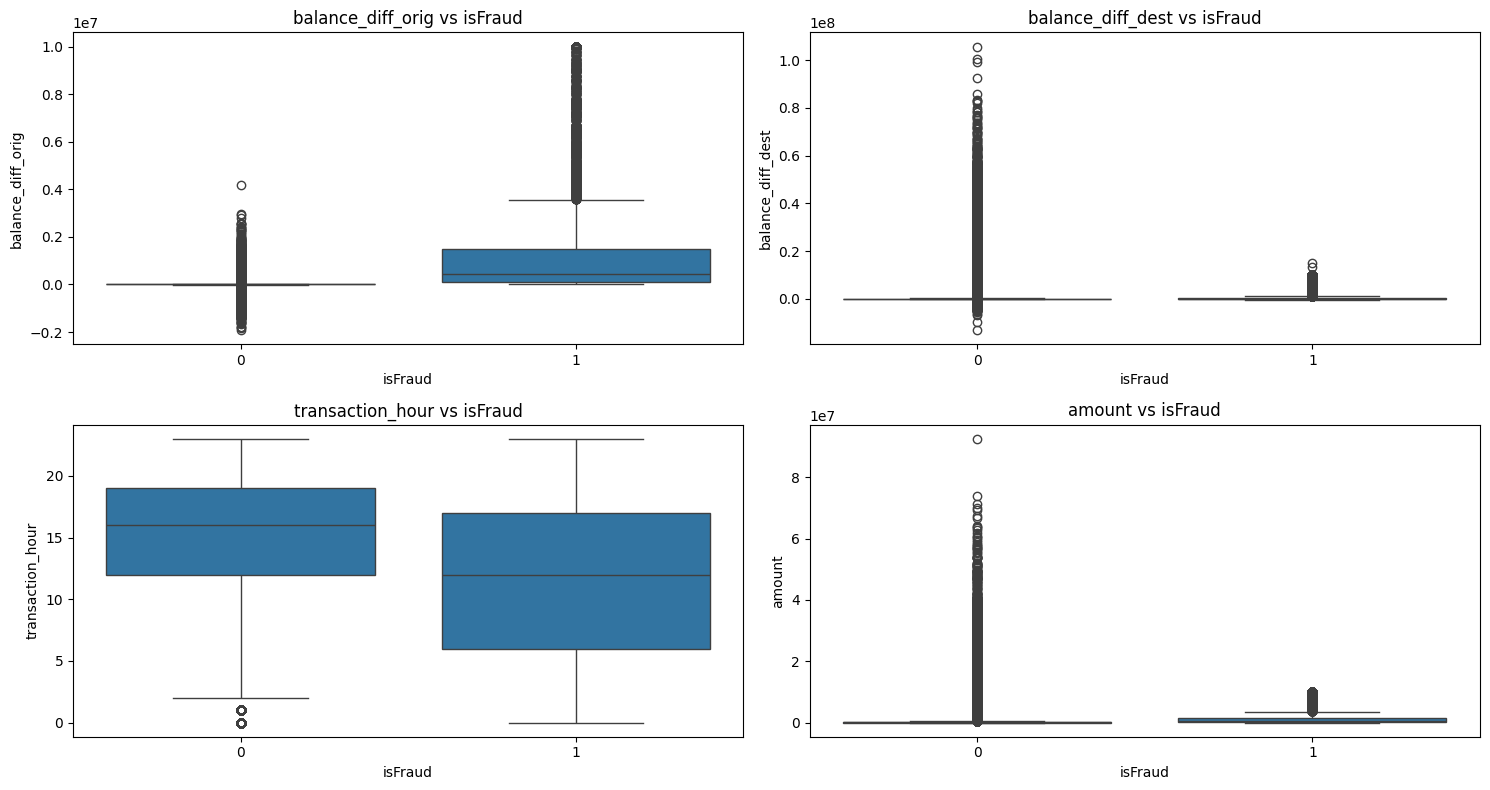

In [20]:
plt.figure(figsize=(15,8))
for i, col in enumerate(['balance_diff_orig', 'balance_diff_dest', 'transaction_hour', 'amount'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=bankDf, x='isFraud', y=col)
    plt.title(f"{col} vs isFraud")
plt.tight_layout()
plt.show()

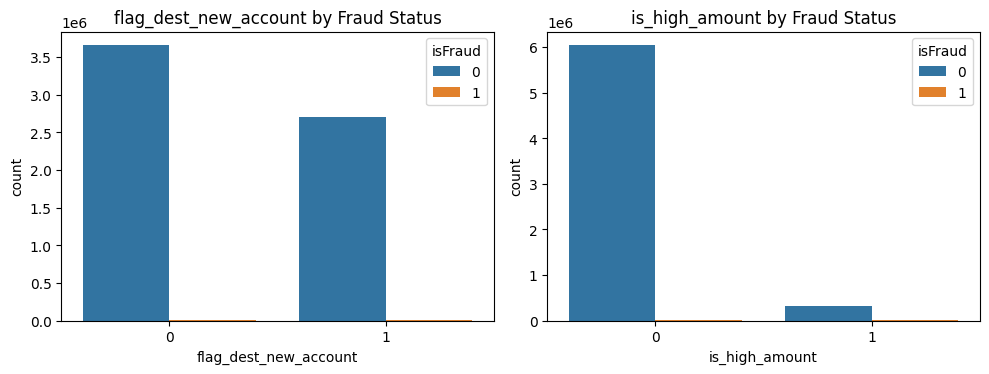

In [21]:
cat_features = ['flag_dest_new_account', 'is_high_amount']
plt.figure(figsize=(10,4))
for i, col in enumerate(cat_features, 1):
    plt.subplot(1, 2, i)
    sns.countplot(data=bankDf, x=col, hue='isFraud')
    plt.title(f"{col} by Fraud Status")
plt.tight_layout()
plt.show()

In [ ]:
sns.pairplot(
    bankDf[['amount', 'balance_diff_orig', 'balance_diff_dest', 'isFraud']],
    hue='isFraud',
    diag_kind='kde',
    plot_kws={'alpha':0.5}
)
plt.show()

In [10]:
bankDf.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'balance_diff_orig', 'balance_diff_dest',
       'flag_dest_new_account', 'transaction_hour', 'is_high_amount'],
      dtype='object')

In [11]:
len(bankDf.columns)

16

In [23]:
cols_to_remove = [
    "nameOrig",
    "nameDest",
    "newbalanceDest",
    "balance_diff_orig",
    "balance_diff_dest",
    "is_high_amount",
    "isFlaggedFraud"
]

In [21]:
from src.data_cleaning import remove_columns


In [24]:
bankDf_cleaned = remove_columns(bankDf, cols_to_remove)

In [25]:
bankDf_cleaned.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'isFraud', 'flag_dest_new_account',
       'transaction_hour'],
      dtype='object')

In [27]:
bankDf_cleaned.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,isFraud,flag_dest_new_account,transaction_hour
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0,1,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0,1,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,1,1,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,1,0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0,1,1


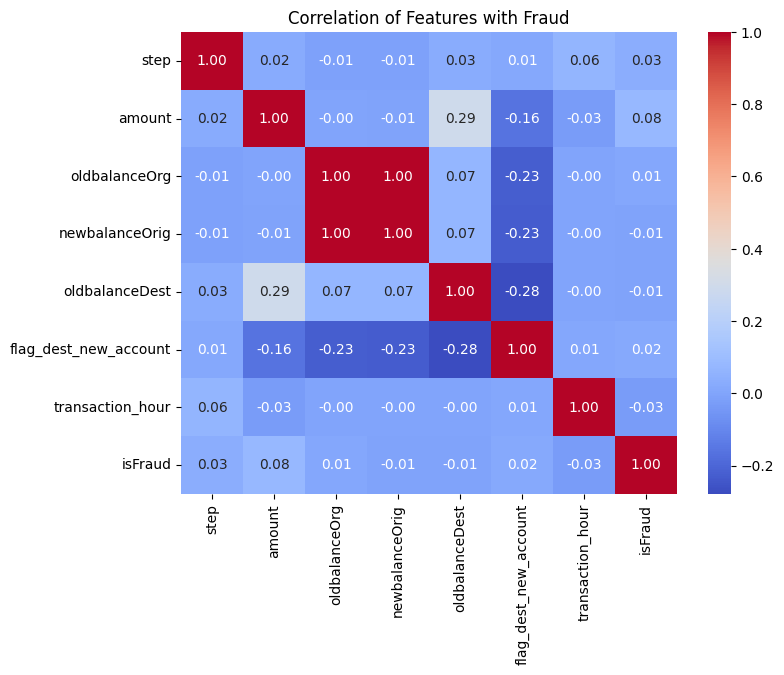

In [28]:
plt.figure(figsize=(8,6))
corr = bankDf_cleaned[["step","amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "flag_dest_new_account", "transaction_hour", "isFraud"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Features with Fraud")
plt.show()

In [26]:
# Save interim cleaned data
bankDf_cleaned.to_csv(os.path.join(DATA_INTERIM, "cleaned_data.csv"), index=False)

In [33]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Train-test split
train_df, test_df = train_test_split(bankDf_cleaned, test_size=0.2, random_state=42, stratify=bankDf_cleaned['isFraud'])

# Save them for modeling
train_df.to_csv(os.path.join(DATA_PROCESSED, "train.csv"), index=False)
test_df.to_csv(os.path.join(DATA_PROCESSED, "test.csv"), index=False)
